In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [21]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

In [22]:
df_fake["fake"] = 1
df_true["fake"] = 0

In [23]:
df_news = pd.concat([df_fake, df_true])

In [24]:
df_news.head(5)

,title,text,subject,date,fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [25]:
#Add title to text
df_news['text'] = df_news['title'] + df_news['text']
df_news.drop(labels=['title'], axis=1, inplace=True)

# Pre-processing Dataset

In [26]:
import nltk
from nltk import pos_tag, pos_tag_sents, word_tokenize
#nltk.download('all')

In [27]:
#Lowercase, remove punctuation, and remove stopwords
def clean_text(text):
    stop_words = set(STOPWORDS)
    text = text.lower()
    text = re.sub(r'\'s','',text) #This is needed to prevent turning nouns into verb when lemmatizing and POS tagging
    text = re.sub(r's\'','',text)
    text = re.sub(r'\'m',' am',text) #Converts I'm to I am
    text = re.sub(r'n\'t',' not',text) #This is needed to convert the n't to not. 
    text = re.sub(r'[^\w\s]','',text)
    
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
  
    return filtered_sentence
  
df_news['text_clean'] = df_news['text'].apply(lambda x: clean_text(x))



In [28]:
df_news['text_clean'].head(5)

0    [donald, trump, sends, embarrassing, new, year...
1    [drunk, bragging, trump, staffer, started, rus...
2    [sheriff, david, clarke, becomes, internet, jo...
3    [trump, obsessed, even, obamas, name, coded, w...
4    [pope, francis, called, donald, trump, christm...
Name: text_clean, dtype: object

In [29]:
df_news['text_joined'] = df_news['text_clean'].apply(lambda x: ' '.join(x))
df_news['text_joined'].head(5)

0    donald trump sends embarrassing new years eve ...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obamas name coded website ...
4    pope francis called donald trump christmas spe...
Name: text_joined, dtype: object

In [30]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

#Perform POS tagging and lemmatization.

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    
    return tag_dict.get(tag, wordnet.NOUN)


# 1. Init Lemmatizer
lemmatizer = WordNetLemmatizer()

# 2. Lemmatize a Sentence with the appropriate POS tag
df_news['text_lemmPOS'] = df_news['text_joined'].apply(lambda x: [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])

In [31]:
df_news['text_lemmPOS'].shape

(44898,)

In [32]:
df_news['text_lemmPOS'].head(5)

0    [donald, trump, sends, embarrass, new, year, e...
1    [drunk, bragging, trump, staffer, start, russi...
2    [sheriff, david, clarke, becomes, internet, jo...
3    [trump, obsess, even, obamas, name, cod, websi...
4    [pope, francis, call, donald, trump, christmas...
Name: text_lemmPOS, dtype: object

In [33]:
df_news['text_final'] = df_news['text_lemmPOS'].apply(lambda x: ' '.join(x)) #Join the list of lemmatized, POS tagged words back into a string.

In [34]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          44898 non-null  object
 1   subject       44898 non-null  object
 2   date          44898 non-null  object
 3   fake          44898 non-null  int64 
 4   text_clean    44898 non-null  object
 5   text_joined   44898 non-null  object
 6   text_lemmPOS  44898 non-null  object
 7   text_final    44898 non-null  object
dtypes: int64(1), object(7)
memory usage: 3.1+ MB


In [35]:
df_news.to_csv('news_all_columns.csv')

### Obtaining a non duplicated dataset to test for difference.

In [36]:
df_fake_unique = df_fake.drop_duplicates('text') #Unique values generated from dropping text in fake set
df_true_unique = df_true.drop_duplicates('text') #Unique values generated from dropping text in fake set

In [37]:
df_news_unique = pd.concat([df_fake_unique, df_true_unique])

### Some preprocessing

In [38]:
df_news_unique['text_clean'] = df_news_unique['text'].apply(lambda x: clean_text(x))

In [39]:
df_news_unique['text_joined'] = df_news_unique['text_clean'].apply(lambda x: ' '.join(x))

In [40]:
df_news_unique['text_lemmPOS'] = df_news_unique['text_joined'].apply(lambda x: [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])

In [41]:
df_news_unique['text_final'] = df_news_unique['text_lemmPOS'].apply(lambda x: ' '.join(x))

## Converting & Vectorization

## Not Processed

### Duplicates

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

x_df_dr = df_news['text'] #Features
y_df_dr = df_news['fake'] #Label

count_vectorizer_dr = CountVectorizer() 
tfidf_transformer_dr = TfidfTransformer(norm = "l2") 

vectorized_dr = count_vectorizer_dr.fit_transform(x_df_dr)
#freq_term_matrix = count_vectorizer.transform(x_df) #Equal to vectorized

tf_idf_matrix_dr = tfidf_transformer_dr.fit_transform(vectorized_dr) #Returns a sparse matrix

tf_idf_matrix_transformed_dr = tfidf_transformer_dr.fit(vectorized_dr) #Returns a transformer object

#R = raw d=duplicate n=not duplicate

In [43]:
# Splitting the data into test data and train data
x_train_dr, x_test_dr, y_train_dr, y_test_dr = train_test_split(tf_idf_matrix_dr, y_df_dr, train_size=0.8, test_size=0.2, random_state=42)

## Non-duplicates

In [44]:
x_df_nr = df_news['text'] #Features
y_df_nr = df_news['fake'] #Label

count_vectorizer_nr = CountVectorizer() 
tfidf_transformer_nr = TfidfTransformer(norm = "l2") 

vectorized_nr = count_vectorizer_nr.fit_transform(x_df_nr)
#freq_term_matrix = count_vectorizer.transform(x_df) #Equal to vectorized

tf_idf_matrix_nr = tfidf_transformer_nr.fit_transform(vectorized_nr) #Returns a sparse matrix

tf_idf_matrix_transformed_nr = tfidf_transformer_nr.fit(vectorized_nr) #Returns a transformer object

#R = raw d=duplicate n=not duplicate

In [45]:
# Splitting the data into test data and train data
x_train_nr, x_test_nr, y_train_nr, y_test_nr = train_test_split(tf_idf_matrix_nr, y_df_nr, train_size=0.8, test_size=0.2, random_state=42)

## Processed

### Duplicates vectorization

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

x_df_dp = df_news['text_final'] #Features
y_df_dp = df_news['fake'] #Label

count_vectorizer_dp = CountVectorizer() 
tfidf_transformer_dp = TfidfTransformer(norm = "l2") 

vectorized_dp = count_vectorizer_dp.fit_transform(x_df_dp)
#freq_term_matrix = count_vectorizer.transform(x_df) #Equal to vectorized

tf_idf_matrix_dp = tfidf_transformer_dp.fit_transform(vectorized_dp) #Returns a sparse matrix

tf_idf_matrix_transformed_d = tfidf_transformer_dp.fit(vectorized_dp) #Returns a transformer object

#D = duplicate p=processed

In [47]:
# Splitting the data into test data and train data
x_train_dp, x_test_dp, y_train_dp, y_test_dp = train_test_split(tf_idf_matrix_dp, y_df_dp, train_size=0.8, test_size=0.2, random_state=42)

### Non-Duplicates Vectorization

In [53]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

x_df_np = df_news_unique['text_final'] #Features
y_df_np = df_news_unique['fake'] #Label

count_vectorizer_np = CountVectorizer() 
tfidf_transformer_np = TfidfTransformer(norm = "l2") 

vectorized_np = count_vectorizer_np.fit_transform(x_df_np)
#freq_term_matrix = count_vectorizer.transform(x_df) #Equal to vectorized

tf_idf_matrix_np = tfidf_transformer_np.fit_transform(vectorized_np) #Returns a sparse matrix

tf_idf_matrix_transformed = tfidf_transformer_np.fit(vectorized_np) #Returns a transformer object


In [54]:
# Splitting the data into test data and train data
x_train_np, x_test_np, y_train_np, y_test_np = train_test_split(tf_idf_matrix_np, y_df_np, train_size=0.8, test_size=0.2, random_state=42)

# Models

## Processed

### Logistic Regression Non-Dup

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

logreg = LogisticRegression()
logreg_model_np = logreg.fit(x_train_np, y_train_np)

y_pred_logreg_np = logreg.predict(x_test_np)

accuracy_log_np = accuracy_score(y_test_np, y_pred_logreg_np)
print(f'Accuracy: {round(accuracy_log_np*100,2)}%')

Accuracy: 98.65%


In [56]:
print(classification_report(y_test_np, y_pred_logreg_np))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4230
           1       0.99      0.98      0.99      3500

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



In [57]:
from sklearn.metrics import confusion_matrix  
cm_log_np = confusion_matrix(y_test_np, y_pred_logreg_np)  
print(cm_log_np)
print("[[TN  FP]\n [FN  TP]]")

[[4194   36]
 [  68 3432]]
[[TN  FP]
 [FN  TP]]


In [58]:
from sklearn import metrics
#use model to predict probability that given y value is 1
y_pred_proba_log_np = logreg_model_np.predict_proba(x_test_np)[::,1]

#calculate AUC of model
auc_log_np = metrics.roc_auc_score(y_test_np, y_pred_proba_log_np)

#print AUC score
print(f'AUC: {round(auc_log_np*100,2)}%')


AUC: 99.84%


### Logistic Regression Dup

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

logreg_dp= LogisticRegression()
logreg_model_dp = logreg_dp.fit(x_train_dp, y_train_dp)

y_pred_logreg_dp= logreg_dp.predict(x_test_dp)

accuracy_log_dp = accuracy_score(y_test_dp, y_pred_logreg_dp)
print(f'Accuracy: {round(accuracy_log_dp*100,2)}%')

Accuracy: 98.7%


In [60]:
print(classification_report(y_test_dp, y_pred_logreg_dp))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4247
           1       0.99      0.99      0.99      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [61]:
from sklearn.metrics import confusion_matrix  
cm_log_dp = confusion_matrix(y_test_dp, y_pred_logreg_dp)  
print(cm_log_dp)
print("[[TN  FP]\n [FN  TP]]")

[[4191   56]
 [  61 4672]]
[[TN  FP]
 [FN  TP]]


In [62]:
from sklearn import metrics
#use model to predict probability that given y value is 1
y_pred_proba_log_d = logreg_model_dp.predict_proba(x_test_dp)[::,1]

#calculate AUC of model
auc_log_dp = metrics.roc_auc_score(y_test_dp, y_pred_proba_log_d)

#print AUC score
print(f'AUC: {round(auc_log_dp*100,2)}%')


AUC: 99.83%


### Nayve-Bayes Non-Dup


In [63]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
nb_model_np = NB.fit(x_train_np, y_train_np)
y_pred_nb_np = NB.predict(x_test_np)
accuracy_nb_np = accuracy_score(y_test_np, y_pred_nb_np)
print(f'Accuracy: {round(accuracy_nb_np*100,2)}%')

Accuracy: 92.17%


In [64]:
print(classification_report(y_test_np, y_pred_nb_np))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      4230
           1       0.98      0.84      0.91      3500

    accuracy                           0.92      7730
   macro avg       0.93      0.92      0.92      7730
weighted avg       0.93      0.92      0.92      7730



In [65]:
cm_nb_np = confusion_matrix(y_test_np, y_pred_nb_np)  
print(cm_nb_np)
print("[[TN  FP]\n [FN  TP]]")

[[4168   62]
 [ 543 2957]]
[[TN  FP]
 [FN  TP]]


In [66]:
#use model to predict probability that given y value is 1
y_pred_proba_nb_np = nb_model_np.predict_proba(x_test_np)[::,1]

#calculate AUC of model
auc_nb_np = metrics.roc_auc_score(y_test_np, y_pred_proba_nb_np)

#print AUC score
print(f'AUC: {round(auc_nb_np*100,2)}%')


AUC: 98.5%


### Nayve-Bayes Dup


In [67]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
nb_model_dp = NB.fit(x_train_dp, y_train_dp)
y_pred_nb_dp = NB.predict(x_test_dp)
accuracy_nb_dp = accuracy_score(y_test_dp, y_pred_nb_dp)
print(f'Accuracy: {round(accuracy_nb_dp*100,2)}%')

Accuracy: 94.1%


In [68]:
print(classification_report(y_test_dp, y_pred_nb_dp))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4247
           1       0.94      0.95      0.94      4733

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



In [69]:
cm_nb_dp = confusion_matrix(y_test_dp, y_pred_nb_dp)  
print(cm_nb_dp)
print("[[TN  FP]\n [FN  TP]]")

[[3973  274]
 [ 256 4477]]
[[TN  FP]
 [FN  TP]]


In [70]:
#use model to predict probability that given y value is 1
y_pred_proba_nb_d = nb_model_dp.predict_proba(x_test_dp)[::,1]

#calculate AUC of model
auc_nb_dp = metrics.roc_auc_score(y_test_dp, y_pred_proba_nb_d)

#print AUC score
print(f'AUC: {round(auc_nb_dp*100,2)}%')


AUC: 98.42%


### Passive Aggressive Non-dup

In [71]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac_np=PassiveAggressiveClassifier(max_iter=50)
pac_model_np = pac_np.fit(x_train_np,y_train_np)

#Predict on the test set and calculate accuracy
y_pred_pac_np =pac_np.predict(x_test_np)
    
accuracy_pac_np=accuracy_score(y_test_np,y_pred_pac_np)
print(f'Accuracy: {round(accuracy_pac_np*100,2)}%')

Accuracy: 99.39%


In [72]:
print(classification_report(y_test_np, y_pred_pac_np))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4230
           1       1.00      0.99      0.99      3500

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730



In [73]:
cm_pac_np = confusion_matrix(y_test_np, y_pred_pac_np)  
print(cm_pac_np)
print("[[TN  FP]\n [FN  TP]]")

[[4214   16]
 [  31 3469]]
[[TN  FP]
 [FN  TP]]


In [74]:
#use model to predict probability that given y value is 1
y_pred_proba_pac_np = pac_model_np._predict_proba_lr(x_test_np)[::,1]

#calculate AUC of model
auc_pac_np = metrics.roc_auc_score(y_test_np, y_pred_proba_pac_np)

#print AUC score
print(f'AUC: {round(auc_pac_np*100,2)}%')

AUC: 99.94%


### Passive Aggressive Dup

In [75]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac_model_dp = pac.fit(x_train_dp,y_train_dp)

#Predict on the test set and calculate accuracy
y_pred_pac_dp =pac.predict(x_test_dp)
    
accuracy_pac_dp =accuracy_score(y_test_dp,y_pred_pac_dp)
print(f'Accuracy: {round(accuracy_pac_dp*100,2)}%')

Accuracy: 99.51%


In [76]:
print(classification_report(y_test_dp, y_pred_pac_dp))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4247
           1       0.99      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [77]:
cm_pac_dp = confusion_matrix(y_test_dp, y_pred_pac_dp)  
print(cm_pac_dp)
print("[[TN  FP]\n [FN  TP]]")

[[4222   25]
 [  19 4714]]
[[TN  FP]
 [FN  TP]]


In [78]:
#use model to predict probability that given y value is 1
y_pred_proba_pac_dp = pac_model_dp._predict_proba_lr(x_test_dp)[::,1]

#calculate AUC of model
auc_pac_dp = metrics.roc_auc_score(y_test_dp, y_pred_proba_pac_dp)

#print AUC score
print(f'AUC: {round(auc_pac_dp*100,2)}%')

AUC: 99.96%


## Processed

### kNN

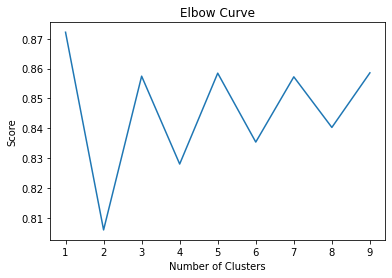

In [80]:
from sklearn.neighbors import KNeighborsClassifier
#Finding the optimum number of clusters for k-means clustering
cluster_numbers = range(1, 10)
kmeans = [KNeighborsClassifier(n_neighbors=i) for i in cluster_numbers]
kmeans
score = [kmeans[i].fit(x_train_dp,y_train_dp).score(x_test_dp, y_test_dp) for i in range(len(kmeans))]
score
plt.plot(cluster_numbers,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

# knn seems to produce worse score than others, we will not use it.

In [81]:
#Lets try to normalize and try kNN again
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
x_train_scaled = scaler.fit_transform(x_train_dp)
x_test_scaled = scaler.transform(x_test_dp)



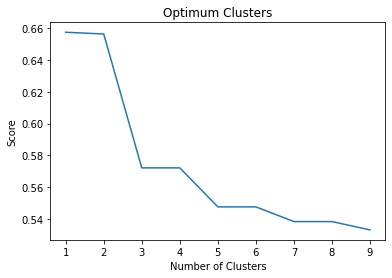

In [82]:
from sklearn.neighbors import KNeighborsClassifier
#Finding the optimum number of clusters for k-means clustering
cluster_numbers = range(1, 10)
kmeans = [KNeighborsClassifier(n_neighbors=i) for i in cluster_numbers]
kmeans
score = [kmeans[i].fit(x_train_scaled,y_train_dp).score(x_test_scaled, y_test_dp) for i in range(len(kmeans))]
score
plt.plot(cluster_numbers,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Optimum Clusters')
plt.show()

# Normalization seems to not have helped to produce a better score. We will not use it.

### Not perfoming kNN on non-duplicated

# Non-Processed

## Logistic Regression Raw Duplicates

In [83]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

logreg_dr= LogisticRegression()
logreg_model_dr = logreg_dr.fit(x_train_dr, y_train_dr)

y_pred_logreg_dr= logreg_dr.predict(x_test_dr)

accuracy_log_dr = accuracy_score(y_test_dr, y_pred_logreg_dr)
print(f'Accuracy: {round(accuracy_log_dr*100,2)}%')

print(classification_report(y_test_dr, y_pred_logreg_dr))

from sklearn.metrics import confusion_matrix  
cm_log_dr = confusion_matrix(y_test_dr, y_pred_logreg_dr)  
print(cm_log_dr)
print("[[TN  FP]\n [FN  TP]]")

from sklearn import metrics
#use model to predict probability that given y value is 1
y_pred_proba_log_d = logreg_model_dr.predict_proba(x_test_dr)[::,1]

#calculate AUC of model
auc_log_dr = metrics.roc_auc_score(y_test_dr, y_pred_proba_log_d)

#print AUC score
print(f'AUC: {round(auc_log_dr*100,2)}%')


Accuracy: 98.81%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4247
           1       0.99      0.99      0.99      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

[[4198   49]
 [  58 4675]]
[[TN  FP]
 [FN  TP]]
AUC: 99.8%


## Logistic Regression Raw Non-Duplicates

In [84]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

logreg = LogisticRegression()
logreg_model_nr = logreg.fit(x_train_nr, y_train_nr)

y_pred_logreg_nr = logreg.predict(x_test_nr)

accuracy_log_nr = accuracy_score(y_test_nr, y_pred_logreg_nr)
print(f'Accuracy: {round(accuracy_log_nr*100,2)}%')


print(classification_report(y_test_nr, y_pred_logreg_nr))

from sklearn.metrics import confusion_matrix  
cm_log_nr = confusion_matrix(y_test_nr, y_pred_logreg_nr)  
print(cm_log_nr)
print("[[TN  FP]\n [FN  TP]]")

from sklearn import metrics
#use model to predict probability that given y value is 1
y_pred_proba_log_nr = logreg_model_nr.predict_proba(x_test_nr)[::,1]

#calculate AUC of model
auc_log_nr = metrics.roc_auc_score(y_test_nr, y_pred_proba_log_nr)

#print AUC score
print(f'AUC: {round(auc_log_nr*100,2)}%')

Accuracy: 98.81%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4247
           1       0.99      0.99      0.99      4733

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

[[4198   49]
 [  58 4675]]
[[TN  FP]
 [FN  TP]]
AUC: 99.8%


## Nayve Bayes Raw and Duplicate

In [85]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
nb_model_dr = NB.fit(x_train_dr, y_train_dr)
y_pred_nb_dr = NB.predict(x_test_dr)
accuracy_nb_dr = accuracy_score(y_test_dr, y_pred_nb_dr)
print(f'Accuracy: {round(accuracy_nb_dr*100,2)}%')

print(classification_report(y_test_dr, y_pred_nb_dr))

cm_nb_dr = confusion_matrix(y_test_dr, y_pred_nb_dr)  
print(cm_nb_dr)
print("[[TN  FP]\n [FN  TP]]")

#use model to predict probability that given y value is 1
y_pred_proba_nb_dr = nb_model_dr.predict_proba(x_test_dr)[::,1]

#calculate AUC of model
auc_nb_dr = metrics.roc_auc_score(y_test_dr, y_pred_proba_nb_dr)

#print AUC score
print(f'AUC: {round(auc_nb_dr*100,2)}%')

Accuracy: 93.61%
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4247
           1       0.92      0.96      0.94      4733

    accuracy                           0.94      8980
   macro avg       0.94      0.93      0.94      8980
weighted avg       0.94      0.94      0.94      8980

[[3878  369]
 [ 205 4528]]
[[TN  FP]
 [FN  TP]]
AUC: 98.39%


## Nayve Bayes Raw and Non-Duplicates


In [86]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
nb_model_nr = NB.fit(x_train_nr, y_train_nr)
y_pred_nb_nr = NB.predict(x_test_nr)
accuracy_nb_nr = accuracy_score(y_test_nr, y_pred_nb_nr)
print(f'Accuracy: {round(accuracy_nb_nr*100,2)}%')

print(classification_report(y_test_nr, y_pred_nb_nr))

cm_nb_nr = confusion_matrix(y_test_nr, y_pred_nb_nr)  
print(cm_nb_nr)
print("[[TN  FP]\n [FN  TP]]")

#use model to predict probability that given y value is 1
y_pred_proba_nb_nr = nb_model_nr.predict_proba(x_test_nr)[::,1]

#calculate AUC of model
auc_nb_nr = metrics.roc_auc_score(y_test_nr, y_pred_proba_nb_nr)

#print AUC score
print(f'AUC: {round(auc_nb_nr*100,2)}%')

Accuracy: 93.61%
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4247
           1       0.92      0.96      0.94      4733

    accuracy                           0.94      8980
   macro avg       0.94      0.93      0.94      8980
weighted avg       0.94      0.94      0.94      8980

[[3878  369]
 [ 205 4528]]
[[TN  FP]
 [FN  TP]]
AUC: 98.39%


## Passive Aggression Raw and Duplicates

In [87]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac=PassiveAggressiveClassifier(max_iter=50)
pac_model_dr = pac.fit(x_train_dr,y_train_dr)

#Predict on the test set and calculate accuracy
y_pred_pac_dr =pac_model_dr.predict(x_test_dr)
    
accuracy_pac_dr =accuracy_score(y_test_dr,y_pred_pac_dr)
print(f'Accuracy: {round(accuracy_pac_dr*100,2)}%')

print(classification_report(y_test_dr, y_pred_pac_dr))

print(classification_report(y_test_dr, y_pred_pac_dr))

#use model to predict probability that given y value is 1
y_pred_proba_pac_dr = pac_model_dr._predict_proba_lr(x_test_dr)[::,1]

#calculate AUC of model
auc_pac_dr = metrics.roc_auc_score(y_test_dr, y_pred_proba_pac_dr)

#print AUC score
print(f'AUC: {round(auc_pac_dr*100,2)}%')

Accuracy: 99.6%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

AUC: 99.94%


## Passive Aggression Raw and Non-Duplicates

In [88]:
from sklearn.linear_model import PassiveAggressiveClassifier
pac_nr=PassiveAggressiveClassifier(max_iter=50)
pac_model_nr = pac_nr.fit(x_train_nr,y_train_nr)

#Predict on the test set and calculate accuracy
y_pred_pac_nr =pac_nr.predict(x_test_nr)
    
accuracy_pac_nr=accuracy_score(y_test_nr,y_pred_pac_nr)
print(f'Accuracy: {round(accuracy_pac_nr*100,2)}%')

print(classification_report(y_test_nr, y_pred_pac_nr))

cm_pac_nr = confusion_matrix(y_test_nr, y_pred_pac_nr)  
print(cm_pac_nr)
print("[[TN  FP]\n [FN  TP]]")

#use model to predict probability that given y value is 1
y_pred_proba_pac_nr = pac_model_nr._predict_proba_lr(x_test_nr)[::,1]

#calculate AUC of model
auc_pac_nr = metrics.roc_auc_score(y_test_nr, y_pred_proba_pac_nr)

#print AUC score
print(f'AUC: {round(auc_pac_nr*100,2)}%')

Accuracy: 99.61%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4247
           1       1.00      1.00      1.00      4733

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980

[[4228   19]
 [  16 4717]]
[[TN  FP]
 [FN  TP]]
AUC: 99.93%


## Let's do some manual testing!

In [89]:
def output_lable(n):
    if n == 1:
        return "Fake News"
    elif n == 0:
        return "Not A Fake News"
    
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    
    new_def_test['text'] = new_def_test['text'].apply(lambda x: clean_text(x))
    new_def_test["text"] = new_def_test["text"].apply(lambda x: ' '.join(x))
    
    new_def_test['text_lemm'] = new_def_test['text'].apply(lambda x: [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)])
    
    new_def_test['text_final'] = new_def_test['text_lemm'].apply(lambda x: ' '.join(x)) #Join the list of lemmatized, POS tagged words back into a string.
    
    new_x_test = new_def_test["text_final"]
    
    #Perform same vectorization on test data
    vectorized_test = count_vectorizer_dp.transform(new_x_test)
    x_newv_testing = tfidf_transformer_dp.transform(vectorized_test)

    pred_LR = logreg_model_dp.predict(x_newv_testing)
    pred_NB = nb_model_dp.predict(x_newv_testing)
    pred_PA = pac_model_dp.predict(x_newv_testing)
    return print("\n\nLR Prediction: {} \nNB Prediction: {} \nPAC Prediction: {}".format(output_lable(pred_LR[0]),                                                                                                    
                                                                                                              output_lable(pred_NB[0]), 
                                                                                                              output_lable(pred_PA[0])))

In [90]:
news = str(input())
manual_testing(news)



LR Prediction: Fake News 
NB Prediction: Fake News 
PAC Prediction: Fake News


### Sample Text:
Dina Boluarte has been sworn in as Peru’s new president after left-wing leader Pedro Castillo was removed in an impeachment trial and arrested following his attempt to illegally shut down Congress.

The opposition-led legislature on Wednesday afternoon overwhelmingly voted in favour of removing Castillo, who earlier in the day had announced plans to “temporarily” dissolve the legislature and rule by decree.

Castillo had said the move aimed to “reestablish the rule of law and democracy” in Peru but it was widely condemned by opposition leaders and others, including Boluarte, his vice president, as an attempted “coup”.

Congress asked 60-year-old Boluarte to take over following its impeachment vote, making her the first woman to lead the South American nation. She was sworn in as president until 2026.

Boluarte called for a political truce to overcome the crisis and said a new cabinet inclusive of all political stripes would be formed. “There has been an attempted coup … that has not found an echo in the institutions, nor in the street,” she said after her swearing-in.

“What I ask for is space, time to rescue the country,” she added.